### HMM Testing on Penn Dataset

In [1]:
import torch


import nltk
from nltk.corpus import treebank
import numpy as np
from nltk.tag import map_tag
from collections import defaultdict, Counter

nltk.download('treebank')
nltk.download('universal_tagset')

start_tag = '^'

data = treebank.tagged_sents(tagset='universal')




tags = set(tag for sent in data for _, tag in sent)
sorted_tags = sorted(tags)
sorted_tags.append(start_tag)
print(sorted_tags)


sent_by_word = []
sent_by_tag = []
for sent in data:
    s = []
    t = []
    for word, tag in sent:
        s.append(word)
        t.append(tag)
    sent_by_word.append(s)
    sent_by_tag.append(t)
print(len(sent_by_word))
print(len(sent_by_tag))

X_test = sent_by_word
y_test = sent_by_tag



words = [word for sent in data for word, tag in sent]
words = set(words)
vocab_size = len(words)
print(vocab_size)


tag_to_idx = {c:i for i, c in enumerate(sorted_tags)}
idx_to_tag = {i:c for i, c in enumerate(sorted_tags)}

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X', '^']
3914
3914
12408


In [2]:
def get_answer(input_words):
    # Use only the last fold
    pos_tags = viterbi_algo(input_words, 0)
    return pos_tags

In [3]:
def viterbi_algo(sentence, fold_index):
    sentence = sentence.copy()
    sentence.append('.')
    # if re.search(r'[a-zA-Z]',sentence[-1]):
    #   sentence.append('.')
    #   print("Sentence didn't ended with a .")
    viterbi_table = [{} for _ in range(len(sentence))]
    backpointer = [{} for _ in range(len(sentence))]
    emission_prob = emission_prob_list[fold_index]
    transition_prob = transition_prob_list[fold_index]

    for tag in transition_prob[start_tag]:
        word = sentence[0].lower()
        viterbi_table[0][tag] = transition_prob[start_tag].get(tag, 1e-6) * emission_prob.get(word, {}).get(tag, 1e-6)
        backpointer[0][tag] = start_tag

    for t in range(1, len(sentence)):
        word = sentence[t].lower()
        for curr_tag in transition_prob:
            max_prob, best_prev_tag = max(
                (viterbi_table[t-1][prev_tag] * transition_prob[prev_tag].get(curr_tag, 1e-6) * emission_prob.get(word, {}).get(curr_tag, 1e-6), prev_tag)
                for prev_tag in viterbi_table[t-1]
            )
            viterbi_table[t][curr_tag] = max_prob
            backpointer[t][curr_tag] = best_prev_tag

    best_path = []
    best_last_tag = max(viterbi_table[-1], key=viterbi_table[-1].get)
    best_path.append(best_last_tag)
    for t in range(len(sentence) - 1, 0, -1):
        best_last_tag = backpointer[t][best_last_tag]
        best_path.insert(0, best_last_tag)
    best_path.pop()
    return best_path

In [4]:
import json
import numpy as np
from nltk.tag import map_tag
from collections import defaultdict, Counter
import re

start_tag = '^'
# Load JSON from file
with open('emission_prob_list.json', 'r') as f:
    json_data = f.read()

# Convert JSON to Python object
emission_prob_list = json.loads(json_data)
num_folds = len(emission_prob_list)
# Load JSON from file
with open('transition_prob_list.json', 'r') as f:
    json_data = f.read()

# Convert JSON to Python object
transition_prob_list = json.loads(json_data)
sentence = "This is the course."
input_words = re.findall(r"\w+|[^\w\s]", sentence)

get_answer(input_words)

['DET', 'VERB', 'DET', 'NOUN', '.']

In [5]:
import re
from collections import defaultdict, Counter
from tqdm import tqdm

# Initialize confusion matrix
per_pos_accuracy = defaultdict(lambda: defaultdict(int))
for each_tag1 in sorted_tags:
    for each_tag2 in sorted_tags:
        per_pos_accuracy[each_tag1][each_tag2] = 0

tag_predicted = []
actual_tags = []

def get_answer(input_words):
    # Use only the last fold
    pos_tags = viterbi_algo(input_words, 0)
    return pos_tags

# Evaluate on test set with tqdm
num_folds = len(emission_prob_list)

for sent, true_tags in tqdm(zip(X_test, y_test), total=len(X_test), desc="Evaluating"):
    # sent is already a list of words
    pred_tags = get_answer(sent)
    
    actual_tags.extend(true_tags)
    tag_predicted.extend(pred_tags)

    # Update confusion matrix
    for t_true, t_pred in zip(true_tags, pred_tags):
        per_pos_accuracy[t_true][t_pred] += 1

Evaluating: 100%|██████████████████████| 3914/3914 [00:11<00:00, 335.37it/s]


In [6]:
def calc_acc(actual, predicted):
    correct = sum(1 for a, p in zip(actual, predicted) if a == p)
    total = len(actual)
    return (correct / total) * 100

In [7]:
# Compute overall accuracy
test_accuracy = calc_acc(actual_tags, tag_predicted)
print(f"Test accuracy: {test_accuracy:.2f}%")

Test accuracy: 80.55%


### HMM Analysis (Penn Dataset)

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(actual_tags, tag_predicted)
precision = precision_score(actual_tags, tag_predicted, average="weighted")
recall = recall_score(actual_tags, tag_predicted, average="weighted")
f1 = f1_score(actual_tags, tag_predicted, average="weighted")

print(f"Accuracy : {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall   : {recall:.2f}")
print(f"F1 Score : {f1:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy : 0.81
Precision: 0.76
Recall   : 0.81
F1 Score : 0.78


In [9]:
from sklearn.metrics import classification_report
print(classification_report(actual_tags, tag_predicted))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           .       0.89      0.91      0.90     11715
         ADJ       0.77      0.82      0.79      6397
         ADP       0.74      0.97      0.84      9857
         ADV       0.87      0.78      0.83      3171
        CONJ       0.99      0.99      0.99      2265
         DET       0.71      0.94      0.81      8725
        NOUN       0.87      0.85      0.86     28867
         NUM       0.72      0.64      0.68      3546
        PRON       0.67      0.69      0.68      2737
         PRT       0.65      0.40      0.49      3219
        VERB       0.80      0.92      0.86     13564
           X       0.00      0.00      0.00      6613
           ^       0.00      0.00      0.00         0

    accuracy                           0.81    100676
   macro avg       0.67      0.69      0.67    100676
weighted avg       0.76      0.81      0.78    100676



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Per-POS Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix

labels = sorted_tags
cm = confusion_matrix(actual_tags, tag_predicted, labels=labels)

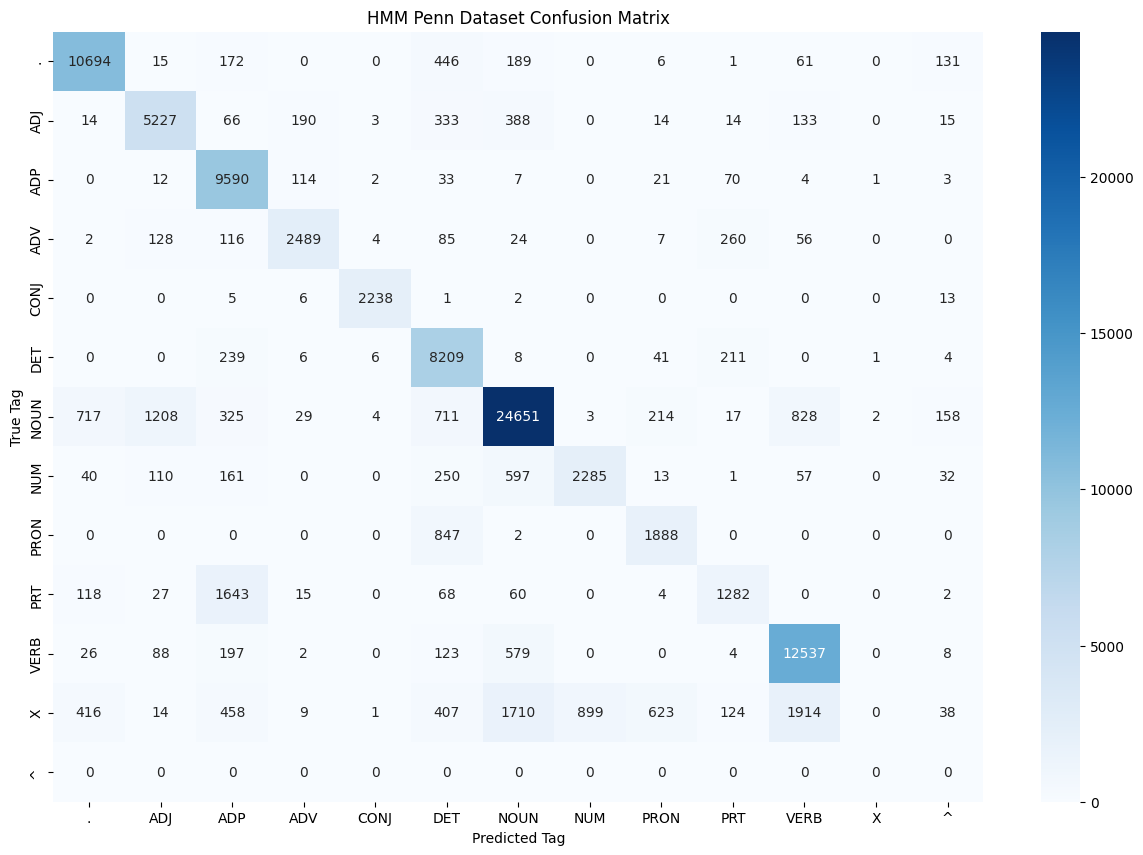

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Tag")
plt.ylabel("True Tag")
plt.title("HMM Penn Dataset Confusion Matrix")
plt.show()

In [23]:
per_pos_accur = defaultdict(dict)
per_pos_counts = per_pos_accuracy
for true_tag, pred_dict in per_pos_counts.items():
    total = sum(pred_dict.values())
    correct = pred_dict.get(true_tag, 0)
    per_pos_accur[true_tag] = {
        "Accuracy": correct / total if total > 0 else 0.0,
        "Support": total
    }

# Make fancy DataFrame
per_pos_acc_df = pd.DataFrame.from_dict(per_pos_accur, orient="index")
per_pos_acc_df = per_pos_acc_df.sort_values("Support", ascending=False)

# Round accuracy to 3 decimals
per_pos_acc_df["Accuracy"] = per_pos_acc_df["Accuracy"].round(3)

# Pretty print
print(per_pos_acc_df)

# Convert to LaTeX table
latex_table = per_pos_acc_df.to_latex(
    index=True,
    header=True,
    caption="Per-POS Accuracy for HMM testing on Penn Treebank",
    label="tab:per_pos_acc",
    float_format="%.3f",
    column_format="lrr"  # left align index, right align numeric
)

print(latex_table)

      Accuracy  Support
NOUN     0.854    28867
VERB     0.924    13564
.        0.913    11715
ADP      0.973     9857
DET      0.941     8725
X        0.000     6613
ADJ      0.817     6397
NUM      0.644     3546
PRT      0.398     3219
ADV      0.785     3171
PRON     0.690     2737
CONJ     0.988     2265
^        0.000        0


In [25]:
# Round for readability
per_pos_acc_df["Accuracy"] = per_pos_acc_df["Accuracy"].round(3)

# Print in LaTeX-like table style
print("Table: Per-POS Accuracy for HMM testing on Penn Treebank\n")
print(f"{'POS':<8} {'Accuracy':>10} {'Support':>10}")
print("-" * 32)
for pos, row in per_pos_acc_df.iterrows():
    print(f"{pos:<8} {row['Accuracy']:>10.3f} {int(row['Support']):>10}")

Table: Per-POS Accuracy for HMM testing on Penn Treebank

POS        Accuracy    Support
--------------------------------
NOUN          0.854      28867
VERB          0.924      13564
.             0.913      11715
ADP           0.973       9857
DET           0.941       8725
X             0.000       6613
ADJ           0.817       6397
NUM           0.644       3546
PRT           0.398       3219
ADV           0.785       3171
PRON          0.690       2737
CONJ          0.988       2265
^             0.000          0


In [26]:
# Round accuracy for readability
per_pos_acc_df["Accuracy"] = per_pos_acc_df["Accuracy"].round(3)

# Convert to LaTeX table
latex_table = per_pos_acc_df.to_latex(
    index=True,
    header=True,
    caption="Per-POS Accuracy for HMM testing on Penn Treebank",
    label="tab:per_pos_acc",
    float_format="%.3f",
    column_format="lrr"  # left align index, right align numeric
)

print(latex_table)

\begin{table}
\caption{Per-POS Accuracy for HMM testing on Penn Treebank}
\label{tab:per_pos_acc}
\begin{tabular}{lrr}
\toprule
 & Accuracy & Support \\
\midrule
NOUN & 0.854 & 28867 \\
VERB & 0.924 & 13564 \\
. & 0.913 & 11715 \\
ADP & 0.973 & 9857 \\
DET & 0.941 & 8725 \\
X & 0.000 & 6613 \\
ADJ & 0.817 & 6397 \\
NUM & 0.644 & 3546 \\
PRT & 0.398 & 3219 \\
ADV & 0.785 & 3171 \\
PRON & 0.690 & 2737 \\
CONJ & 0.988 & 2265 \\
^ & 0.000 & 0 \\
\bottomrule
\end{tabular}
\end{table}



In [2]:
sorted_tags

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X',
 '^']